In [ ]:
# written by Liangying, 4/12/2022

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

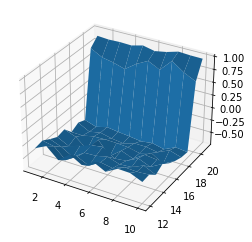

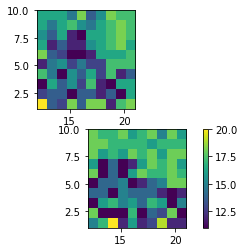

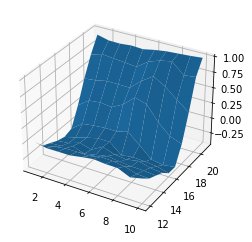

In [2]:
class Players():    
    def __init__(self, state_start, state_end, cards, stick_points):
        self.points = 0
        self.state_start = state_start
        self.state_end = state_end 
        self.cards = cards
        self.stick_points = stick_points
        # Players()这个类是针对每一轮游戏调用的，因此value就不能做为属性，因为他是多轮平均的。
    
    def reset(self):
        self.points = 0
        self.points_next = 0 
        self.ace_usable = 0
        
    def deal_one_card(self):
        return np.random.choice(self.cards)   # p=none时默认为等概率抽取数组中的元素
          
    def Natural(self):   # 第一轮不会爆牌
        self.card1 = self.deal_one_card()   
        self.card2 = self.deal_one_card()   
        self.points_up = self.card1          # 对于dealer,假设card2是不知道的
        if min(self.card1, self.card2) == 1:
            s = 11 + max(self.card1, self.card2)
            if s == 21:
                self.ace_usable = 1
                self.points = 21
                return True
            elif s < 21:
                self.ace_usable = 1
                self.points = s
                return False
        else:
            self.ace_usable = 0
            self.points = self.card1 + self.card2
            return False
            
    def Bust(self):
        if self.points_next > 21:   # 而bust是抽了一个新的牌后，才能判断是不是爆牌
            return True
        else:
            return False
        
    def Stick_player(self):
        if self.points >= self.stick_points:    # 是当前的牌总和决定是否停牌
            return True
        else:
            return False
        
    def Stick_dealer(self):
        if self.points >= self.stick_points:
            return True
        else:
            return False
        
    def Hit(self):    
        new_card = self.deal_one_card()   
        s = 11 + self.points
        if new_card == 1 and s <= 21:
            self.ace_usable = 1
            self.points_next = self.points + 11
        else:
            self.ace_usable = 0
            self.points_next = self.points + new_card
            
        if self.Bust():
            self.points = self.points     # 抽完这张牌后，能不能到达下一个State是由Bust()决定的，没爆才可以进入下一个state
        else:
            self.points = self.points_next
            self.points_up = new_card
        
            
    '''只有Natual()和Hit()这两个函数涉及到抽牌这个动作，故
       Natual()和Hit()函数执行的功能有：1、如果有A,标记A是否可用；
                                        2、抽完这张牌后points加和的变化，即状态的更新；
                                        3、若这个状态在这一幕中出现，则进行+1，数这个状态在这一幕中一共出现了多少次(用来判断是不是首次在本幕中出现)
                                        
       而Bust()和Stick()这两个函数只涉及判断，不再有新的牌加入，所以没有状态的更新'''
    

def state_check(player_points, dealer_points):
    if player_points in np.arange(12,22) and dealer_points in np.arange(1,11):
        return 1
    else:
        return 0
    
    
def state_first_encounter_one_episode(ace_usable, p, d):
    global state_count_Ace_one_episode
    global state_count_one_episode
    
    if state_check(p, d):
        if ace_usable:
            state_count_Ace_one_episode.loc[p,d] += 1
            if state_count_Ace_one_episode.loc[p,d] > 1:
                 state_count_Ace_one_episode.loc[p,d] = 0     # 如果重复遇到了，就设为0
        else:
            state_count_one_episode.loc[p,d] += 1
            if state_count_one_episode.loc[p,d] > 1:
                 state_count_one_episode.loc[p,d] = 0     # 如果重复遇到了，就设为0
            
    
def Value_update(value):
    global state_count_Ace_one_episode,state_count_Ace_across_episodes, value_Ace_across_episodes
    global state_count_one_episode, state_count_across_episodes,value_across_episodes
    
    if 1 in state_count_Ace_one_episode:
        for i in range(12,22):
            for j in range(1,11):
                if state_count_Ace_one_episode.loc[i,j] == 1:
                    state_count_Ace_across_episodes.loc[i,j] += 1
                    value_Ace_across_episodes.loc[i,j] += (value - value_Ace_across_episodes.loc[i,j]) / state_count_Ace_across_episodes.loc[i,j]    
     
    if 1 in state_count_one_episode:
         for i in range(12,22):
             for j in range(1,11):
                 if state_count_one_episode.loc[i,j] == 1:
                     state_count_across_episodes.loc[i,j] += 1
                     value_across_episodes.loc[i,j] += (value - value_across_episodes.loc[i,j]) / state_count_across_episodes.loc[i,j]    
                                  
def reset():
    global state_count_Ace_one_episode,state_count_Ace_across_episodes, value_Ace_across_episodes
    state_count_Ace_one_episode = pd.DataFrame(0,index = np.arange(12,22),columns = np.arange(1,11)) 
    state_count_Ace_across_episodes = pd.DataFrame(0,index = np.arange(12,22),columns = np.arange(1,11))
    value_Ace_across_episodes = pd.DataFrame(0,index = np.arange(12,22),columns = np.arange(1,11))
    
    global state_count_one_episode, state_count_across_episodes,value_across_episodes
    state_count_one_episode = pd.DataFrame(0,index = np.arange(12,22),columns = np.arange(1,11))
    state_count_across_episodes = pd.DataFrame(0,index = np.arange(12,22),columns = np.arange(1,11))
    value_across_episodes = pd.DataFrame(0,index = np.arange(12,22),columns = np.arange(1,11))
        
    
def Monte_Carlo(n, stick_points_player, stick_points_dealer=17):
    
    # 在这个游戏中，状态state是由player和dealer共同决定的！
    # 所以在player和dealer分别的循环内，只需要记录各自的点数，然后两个循环都结束后再判断State和计算Value

    cards = np.arange(1,11)
    player = Players(12,21,cards,stick_points_player)
    dealer = Players(1,10,cards,stick_points_dealer)
    
    for i in range(0,n):
        player.reset()
        dealer.reset()
        player_natural_flag = 0
        dealer_natural_flag = 0
        global state_count_Ace_one_episode 
        state_count_Ace_one_episode.loc[:,:] = 0
        global state_count_one_episode 
        state_count_one_episode.loc[:,:] = 0
        
        player_bust_flag = 0   #判断dealer是否需要抽牌，因为如果player直接bust了，dealer就直接赢了不需要抽牌
        dealer_bust_flag = 0 
        
        player_stick_flag = 0
        dealer_stick_flag = 0
        
        count = 1    # 只是用来判断是否是第一回合的
        
        # For player
        while(True):
            if count == 1:
                if player.Natural() and dealer.Natural():     # 第一种：因为natural而break
                    player_natural_flag = 1
                    dealer_natural_flag = 1
                    state_first_encounter_one_episode(player.ace_usable, player.points, dealer.points_up)
                    count += 1
                    break
                elif player.Natural() and not dealer.Natural(): 
                    player_natural_flag = 1
                    dealer_natural_flag = 0
                    state_first_encounter_one_episode(player.ace_usable, player.points, dealer.points_up)
                    count += 1
                    break
                elif not player.Natural() and dealer.Natural(): 
                    player_natural_flag = 0
                    dealer_natural_flag = 1
                    count += 1
                    state_first_encounter_one_episode(player.ace_usable, player.points, dealer.points_up)
                    break
                else:
                     state_first_encounter_one_episode(player.ace_usable, player.points, dealer.points_up)
                     count += 1
            else:
                if dealer_bust_flag:    # 第二种：因为对方bust而break
                    break
                if player.Bust():      # 第三种：因为自己bust而break
                    player_bust_flag = 1
                    state_first_encounter_one_episode(player.ace_usable, player.points, dealer.points_up)
                    count += 1
                    break
                elif player.Stick_player():    # 第四种：因为stick而break
                    player_stick_flag = 1
                    state_first_encounter_one_episode(player.ace_usable, player.points, dealer.points_up)
                    count += 1
                    break
                else:               # 第五种：继续抽牌hit
                    player.Hit()
                    state_first_encounter_one_episode(player.ace_usable, player.points, dealer.points_up)
                    count += 1
                    
        
        # For dealer
        while(True):
            if player_bust_flag:  # 第二种：因为对方bust而break
                break
            if dealer.Bust():      # 第三种：因为自己bust而break
                state_first_encounter_one_episode(player.ace_usable, player.points, dealer.points_up)
                dealer_bust_flag = 1  
                break
            elif dealer.Stick_dealer():    # 第四种：因为stick而break
                dealer_stick_flag = 1
                state_first_encounter_one_episode(player.ace_usable, player.points, dealer.points_up)
                break
            else:               # 第五种：继续抽牌hit
                dealer.Hit()
                state_first_encounter_one_episode(player.ace_usable, player.points, dealer.points_up)
            
        
        
        # who win
        if player_natural_flag and dealer_natural_flag:        # 1、player Natural，dealer Natural = 0
            Value_update(0)
        
        if player_natural_flag and not dealer_natural_flag:   # 2、player Natural，dealer not Natural = 1
            Value_update(1)
            
        if not player_natural_flag and dealer_natural_flag:  # 3、player not Natural，dealer Natural = -1
            Value_update(-1)
    
        if dealer_bust_flag:          # 4、dealer bust = 1
            Value_update(1)
        
        if player_bust_flag:          # 5、player bust = -1
            Value_update(-1)
             
        if player_stick_flag and dealer_stick_flag:        # 6、player bust, dealer stick 
            if player.points > dealer.points:
                Value_update(1)
            elif player.points == dealer.points:
                Value_update(0)
            else:
                Value_update(-1)
                
    return  value_Ace_across_episodes, value_across_episodes               
      
        
if __name__ == '__main__':        
   
    # make figures_5.1  --  MC prediction
    reset()
    Monte_Carlo(10000, 20)
    
    df = value_Ace_across_episodes
    df = value_across_episodes
    
    x,y = np.meshgrid(df.columns, df.index)
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    ax.plot_surface(x, y, df)
    plt.show()
    
    
    # make figures_5.2  -- MC_ES
    action_Ace_old = action_Ace = pd.DataFrame(0,index = np.arange(12,22),columns = np.arange(1,11))
    action_old = action = pd.DataFrame(0,index = np.arange(12,22),columns = np.arange(1,11)) 
    
    Q_Ace_old = Q_Ace = pd.DataFrame(-1000,index = np.arange(12,22),columns = np.arange(1,11))
    Q_old = Q = pd.DataFrame(-1000,index = np.arange(12,22),columns = np.arange(1,11))
    
    for stick_rule in range(11,22):
        reset()
      
        Q_Ace, Q = Monte_Carlo(100000, stick_rule)
        action_Ace.loc[:,:] = stick_rule
        action.loc[:,:] = stick_rule
        
        action_Ace_old = np.where(Q_Ace > Q_Ace_old, stick_rule, action_Ace_old)
        action_old = np.where(Q > Q_old, stick_rule, action_old)
        
        # Q_Ace.combine(Q_Ace_old, lambda s1, s2: np.where(s1>s2, s1, s2))
        Q_Ace_old = Q_Ace_old.combine(Q_Ace, np.maximum)
        Q_old = Q_old.combine(Q, np.maximum)
        
  
    
    fig = plt.figure()
    ax1 = fig.add_subplot(211)
    ax2 = fig.add_subplot(212)
   
    img = ax1.imshow(action_Ace_old,extent=[12,21,1,10])
    img = ax2.imshow(action_old,extent=[12,21,1,10])
    fig.colorbar(img)
    plt.show()
    
    df = Q_Ace_old
    df = Q_old
    
    x,y = np.meshgrid(df.columns, df.index)
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    ax.plot_surface(x, y, df)
    plt.show()
    
    
    